In [1]:
run '/Users/pto845/eddata/eddata/dconn.py'

In [2]:
import pandas as pd
import seaborn as sns
sns.set()
conn = Conn('eddata', 'dw')

%matplotlib inline

/Users/pto845/.virtualenvs/ed/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [26]:
q = """
WITH completion_ratios as (
	SELECT
			sft.school_id
			,hsc.school_year
			,MAX(hsc.cohort_count) as graduation_cohort
			,MAX(hsc.student_count) as graduation_cohort_total
			,SUM(hsc.student_count)/SUM(hsc.cohort_count) as graduation_cohort_ratio
			,SUM(CASE WHEN completion_status = 'Completed - Regular' THEN hsc.student_count ELSE NULL END)/MAX(hsc.cohort_count) as graduation_rate
			,SUM(CASE WHEN completion_status = 'Not Completed - Continuing' THEN hsc.student_count ELSE NULL END)/MAX(hsc.cohort_count) as retention_rate
			,SUM(CASE WHEN completion_status = 'Not Completed - Not Continuing' THEN hsc.student_count ELSE NULL END)/MAX(hsc.cohort_count) as dropout_rate
	FROM
			dw.school_ft sft
	JOIN
			raw_data.wisedash_local_school_id wlsi
		ON wlsi.school_id::VARCHAR = sft.local_fk
	JOIN
			raw_data.wisedash_hs_completion hsc
		ON hsc.school_code = wlsi.school_code
		AND hsc.district_code = wlsi.district_code
	WHERE
			hsc.group_by = 'All Students'
		AND timeframe = '4-Year rate'
		AND group_by = 'All Students'
	GROUP BY 1, 2),    
postsecondary_enrollment AS (
SELECT
			sft.school_id
			,pse.school_code
			,pse.district_code
			,pse.school_year
			,SUM(CASE WHEN pse.institution_level = '4-Year' THEN pse.student_count ELSE NULL END)/MAX(pse.group_count) as fouryear
	FROM
			dw.school_ft sft
	JOIN
			raw_data.wisedash_local_school_id wlsi
		ON wlsi.school_id::VARCHAR = sft.local_fk
	JOIN
			raw_data.wisedash_postsecondary_enrollment pse 
		ON pse.school_code = wlsi.school_code
		AND pse.district_code = wlsi.district_code
	WHERE
			pse.group_by = 'All Students'
GROUP BY 1, 2, 3, 4
)
SELECT 
		sft.school_name
		,sft.is_charter
		,act.student_count as cohort_size
		,act.student_count/act.group_count as participation_rate
		,act.average_score
        ,fouryear
		,cr.*
FROM
        dw.school_ft sft
JOIN
        raw_data.wisedash_local_school_id wlsi
    ON wlsi.school_id::VARCHAR = sft.local_fk
JOIN
        raw_data.wisedash_act_statewide act
    ON act.school_code = wlsi.school_code
    AND act.district_code = wlsi.district_code
JOIN 
        completion_ratios cr
	ON cr.school_id = sft.school_id
	AND act.school_year = cr.school_year
JOIN 
        postsecondary_enrollment pse 
    ON pse.school_id = sft.school_id
    AND pse.school_year = act.school_year
WHERE
		act.group_by = 'All Students'
	AND act.group_by_value = 'All Students'
	AND act.test_subject = 'Combined'
	AND act.test_result != 'No Test'
	AND act.test_group = 'ACT'
	AND act.school_code IS NOT NULL;
"""
df = conn.execute_raw_query(q, fmt='df')

In [27]:
df.head()

,school_name,is_charter,cohort_size,participation_rate,average_score,fouryear,school_id,school_year,graduation_cohort,graduation_cohort_total,graduation_cohort_ratio,graduation_rate,retention_rate,dropout_rate
0,Abbotsford Middle/Senior High,False,46.0,0.978723,16.22,0.361111,6502,2014-15,60.0,59.0,0.500000,0.983333,NaN,0.016667
1,Adams-Friendship High,False,109.0,0.956140,15.73,0.465517,6504,2014-15,112.0,107.0,0.333333,0.955357,0.026786,0.017857
2,Albany High,False,20.0,0.952381,17.25,0.588235,6510,2014-15,33.0,27.0,0.333333,0.818182,0.121212,0.060606
3,Algoma High,False,52.0,0.962963,18.81,0.526316,6513,2014-15,50.0,45.0,0.250000,0.900000,0.020000,0.060000
4,Alma High,False,23.0,1.000000,17.48,0.285714,6515,2014-15,17.0,16.0,0.500000,0.941176,0.058824,NaN


In [28]:
df[df.school_id==7787]

,school_name,is_charter,cohort_size,participation_rate,average_score,fouryear,school_id,school_year,graduation_cohort,graduation_cohort_total,graduation_cohort_ratio,graduation_rate,retention_rate,dropout_rate
258,Carmen High School of Science and Technology S...,True,91.0,0.98913,18.4,0.666667,7787,2014-15,64.0,50.0,0.333333,0.78125,0.203125,0.015625


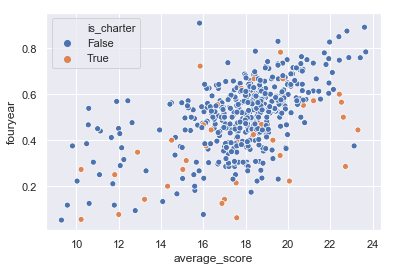

In [31]:
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="average_score", y="fouryear", hue='is_charter', data=df[df.school_year=='2014-15'].set_index('school_id')[['average_score', 'fouryear', 'is_charter']])




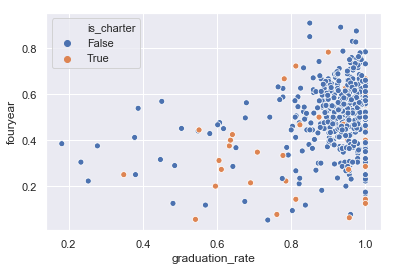

In [32]:
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="graduation_rate", y="fouryear", hue='is_charter', data=df[df.school_year=='2014-15'].set_index('school_id')[['graduation_rate', 'fouryear', 'is_charter']])


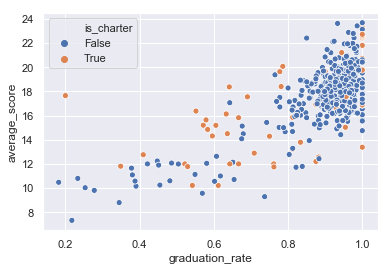

In [33]:
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="graduation_rate", y="average_score", hue='is_charter', data=df[df.school_year=='2014-15'].set_index('school_id')[['graduation_rate', 'average_score', 'is_charter']])


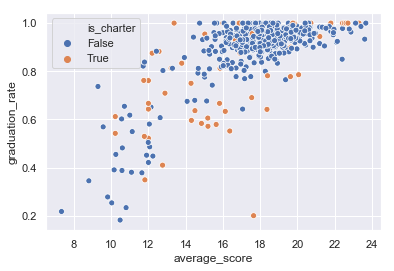

In [29]:
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="average_score", y="graduation_rate", hue='is_charter', data=df[df.school_year=='2014-15'].set_index('school_id')[['average_score', 'graduation_rate', 'is_charter']])

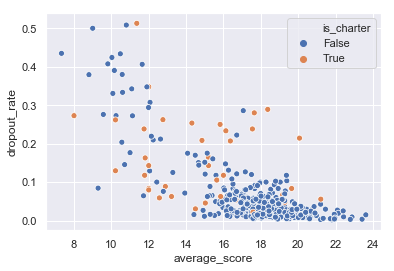

In [20]:
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="average_score", y="dropout_rate", hue='is_charter', data=df[df.school_year=='2014-15'].set_index('school_id')[['average_score', 'dropout_rate', 'is_charter']])




In [24]:
df.set_index('school_id')[['average_score', 'graduation_rate']].plot(kind='scatter')

ValueError: scatter requires an x and y column

In [3]:
import pandas as pd
url = '/Users/pto845/Downloads/sc132a.txt'
data = pd.read_csv(url, sep="\t",)

/Users/pto845/.virtualenvs/ed/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,6,9,22,23,26,28,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
d = {'2013-14': {
				'universe_survey': 'https://nces.ed.gov/ccd/Data/zip/sc132a_txt.zip'
	},
	'2012-13': {
				'universe_survey': 'https://nces.ed.gov/ccd/Data/zip/sc122a_txt.zip'
	},
	'2011-12': {
				'universe_survey': 'https://nces.ed.gov/ccd/Data/zip/sc111a_supp_txt.zip'
	},
	'2010-11': {
				'universe_survey': 'https://nces.ed.gov/ccd/Data/zip/sc102a_txt.zip'			

	},
	'2009-10': {
				'universe_survey': 'https://nces.ed.gov/ccd/data/zip/sc092a_txt.zip'			

	}
}

In [28]:
d

{'2013-14': {'universe_survey': 'https://nces.ed.gov/ccd/Data/zip/sc132a_txt.zip'},
 '2012-13': {'universe_survey': 'https://nces.ed.gov/ccd/Data/zip/sc122a_txt.zip'},
 '2011-12': {'universe_survey': 'https://nces.ed.gov/ccd/Data/zip/sc111a_supp_txt.zip'},
 '2010-11': {'universe_survey': 'https://nces.ed.gov/ccd/Data/zip/sc102a_txt.zip'},
 '2009-10': {'universe_survey': 'https://nces.ed.gov/ccd/data/zip/sc092a_txt.zip'}}

In [26]:
data[~data['BL05F'].isin([-1, -2, -9])]['BL05F'].head(30)
#.where(lambda x: x not in )

9       4
13      1
16      0
18      0
28      0
30      0
37      4
38     11
39     15
41      8
42      5
44      9
45     56
46     10
49      6
50      7
51     11
52     10
54     10
55     10
61      0
62     15
67      3
70     17
85      2
86     43
99     18
101     8
102     5
103    18
Name: BL05F, dtype: int64

In [5]:
data.head().T

,0,1,2,3,4
SURVYEAR,2013,2013,2013,2013,2013
NCESSCH,10000200277,10000201402,10000201667,10000201670,10000201705
FIPST,1,1,1,1,1
LEAID,100002,100002,100002,100002,100002
SCHNO,277,1402,1667,1670,1705
STID,210,210,210,210,210
SEASCH,20,25,50,60,30
LEANM,ALABAMA YOUTH SERVICES,ALABAMA YOUTH SERVICES,ALABAMA YOUTH SERVICES,ALABAMA YOUTH SERVICES,ALABAMA YOUTH SERVICES
SCHNAM,SEQUOYAH SCH - CHALKVILLE CAMPUS,EUFAULA SCH - EUFAULA CAMPUS,CAMPS,DET CTR,WALLACE SCH - MT MEIGS CAMPUS
PHONE,2056808574,3346874441,3342153850,3342153850,3342156039
